# 1. Build A LDA Model of 2012 London Olympics

## 1.1 Packages Importing

In [1]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk import FreqDist
import pandas as pd
import numpy as py
import string
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1.2 Parameters Setting 

In [2]:
col = 2                             # Define which columns are used for topic modelling.
coherence_type = 'c_v'       # Define coherence type
show_coherence_score = False # whether show coherence score
min_len = 4                       # Define the short word length
no_below =  2                   #a threshold filtering out number of occurrence of the tokens among documents  no larger than 5
no_above = 0.9                 #the portion of a word in total corpus size
chunksize = 2000              #Number of documents to be used in each training chunk
eval_every = None             # Don't evaluate model perplexity, takes too much time.
num_topics =  11              #The number of requested latent topics to be extracted from the training corpus.
num_passes = 20              #Number of passes through the corpus during training
iterations = 100                #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
alpha = 50.0/num_topics   #expresses our a-priori belief for each topics’ probability
#eta = 'auto'     
eta =      0.01                  #A-priori belief on word probability
random_state  = 54321     #Either a randomState object or a seed to generate one. Useful for reproducibility.
lemmatization = 1             #Whether implement corpus lemmatization 2:Lemmatizer (without POS tags) 1:Lemmatizer (with POS tags) 0:no

## 1.3 Corpus Reading 

In [3]:
df = pd.read_csv("Olympics-ALL-DOCS.csv", header = None, error_bad_lines=False)

In [4]:
docs = []
docs = df[col]

## 1.4 Data Processing

In [5]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join(['%s' %text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

print('Document number: %d'% (len(docs)))
#freq_words(df[2],10) 

Document number: 169


In [6]:
#Tokenize the corpus 
docs=docs.map(lambda x: x.lower())

tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(docs)):
    docs[i] = tokenizer.tokenize(docs[i])

print('Tokens number: %d'% (len(Dictionary(docs))))
#freq_words(docs,10) 

Tokens number: 19221


In [7]:
#Remove the number
docs = [ [token for token in doc if not token.isnumeric()] for doc in docs]

print('Tokens number after removing number: %d'% (len(Dictionary(docs))))
#freq_words(docs,10) 

Tokens number after removing number: 19221


In [8]:
#remove stop words
stop_words = stopwords.words('english')
stop=[]
sw =  open("C:/Users/jason/Documents/Exeter University/business project/code/stopwords.txt","r")
for i in sw:
    stop.append(i)
sw.close()

stop = [myL.replace('  \n', '') for myL in stop]

stop = [myL.replace('\n', '') for myL in stop]

stop_words.extend(stop)
#print(stop_words)

docs = [ [token for token in doc if not token in stop_words] for doc in docs ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(docs))))
#freq_words(docs,10) 

Tokens number after removing stop words: 18363


In [9]:
#Remove short words (length < min_len)
docs = [ [token for token in doc if not len(token) < min_len] for doc in docs ]
print('Tokens number after removing short words: %d'% (len(Dictionary(docs))))
#freq_words(docs,10) 

Tokens number after removing short words: 17726


In [10]:
# Corpus Lemmatization
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(sentence):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res



if lemmatization == 1:
    for i in range (len(docs)):
        docs[i] = lemmatize_sentence(docs[i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    docs = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in docs ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(docs))))
#freq_words(docs,10) 

Lemmatization with POS tags...
Tokens number after lemmatization: 15286


In [11]:
#remove stop words again
docs = [ [token for token in doc if not token in stop_words] for doc in docs ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(docs))))
#freq_words(docs,10) 

Tokens number after removing stop words: 15165


In [12]:
# Make bigram
bigrams_phases = Phrases(docs, min_count = 10)
for i in range(len(docs)):
    for token in bigrams_phases[docs[i]]:
        if '_' in token:
            docs[i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(docs))))
#freq_words(docs,10) 

Tokens number after adding bigram: 15838


## 1.5 The LDA Model Building

In [13]:
# Build a dictionary
LOdict = Dictionary(docs)

print('Tokens number after creating dictionary: %d'% (len(LOdict)))

Tokens number after creating dictionary: 15838


In [14]:
#Remove  words occur less than no_below documents and more then no_above/documents
LOdict.filter_extremes(no_below = no_below, no_above = no_above)

print('Tokens number after tf-idf: %d'% (len(LOdict)))

Tokens number after tf-idf: 8449


In [15]:
# Create bag of word for corpus
LOcorpus = [LOdict.doc2bow(doc) for doc in docs]

In [16]:
#Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = LOdict 

In [17]:
# Buila a LDA model for LONDON OLYPLMICS
LOldamodel = LdaModel(
    corpus = LOcorpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = alpha,
    eta = eta,
    iterations = iterations,
    num_topics = num_topics,
    passes = num_passes,
    eval_every = eval_every,
    random_state = random_state
)
print('LDA model training complete with number of topics: ', num_topics)

LDA model training complete with number of topics:  11


In [18]:
LOldamodel.print_topics()

[(0,
  '0.032*"cost" + 0.014*"billion" + 0.013*"risk" + 0.013*"government" + 0.013*"public" + 0.012*"figure" + 0.011*"question" + 0.011*"committee" + 0.011*"olympics" + 0.009*"report"'),
 (1,
  '0.011*"lottery" + 0.009*"committee" + 0.009*"cost" + 0.007*"legacy" + 0.006*"fund" + 0.006*"government" + 0.006*"programme" + 0.006*"plan" + 0.005*"national" + 0.005*"funding"'),
 (2,
  '0.022*"benefit" + 0.016*"city" + 0.013*"event" + 0.012*"host" + 0.012*"facility" + 0.012*"company" + 0.011*"support" + 0.011*"legacy" + 0.011*"stag" + 0.011*"park"'),
 (3,
  '0.010*"legacy" + 0.009*"people" + 0.008*"programme" + 0.008*"athlete" + 0.007*"venue" + 0.006*"facility" + 0.006*"committee" + 0.006*"community" + 0.006*"swim" + 0.006*"support"'),
 (4,
  '0.015*"stadium" + 0.012*"country" + 0.009*"olympics" + 0.008*"people" + 0.008*"city" + 0.008*"wembley" + 0.008*"issue" + 0.008*"time" + 0.008*"team" + 0.007*"athletics"'),
 (5,
  '0.057*"transport" + 0.014*"capacity" + 0.014*"plan" + 0.014*"crossrail" + 

In [19]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model = LOldamodel, texts = docs, dictionary = LOdict, coherence=coherence_type)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score ', coherence_type,'=', coherence_lda, ' with number of topics =', num_topics)

Coherence Score  c_v = 0.47260225281532525  with number of topics = 11


In [20]:
# Plot Cohernece Score
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    coherence_values = []
    model_list = []
    for num_topic in range(start, limit, step):
        model=LdaModel(
            corpus = corpus,
            id2word = id2word,
            chunksize = chunksize,
            alpha = alpha,
            eta = eta,
            iterations = iterations,
            num_topics = num_topic,
            passes = num_passes,
            eval_every = eval_every,
            random_state = random_state
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        
        if show_coherence_score == True:
            print('Coherence Score ', coherence_type,'=', coherence_score, ' with number of topics =', num_topic)

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=LOdict, corpus=LOcorpus, texts=docs, start=1, limit=41, step=1)

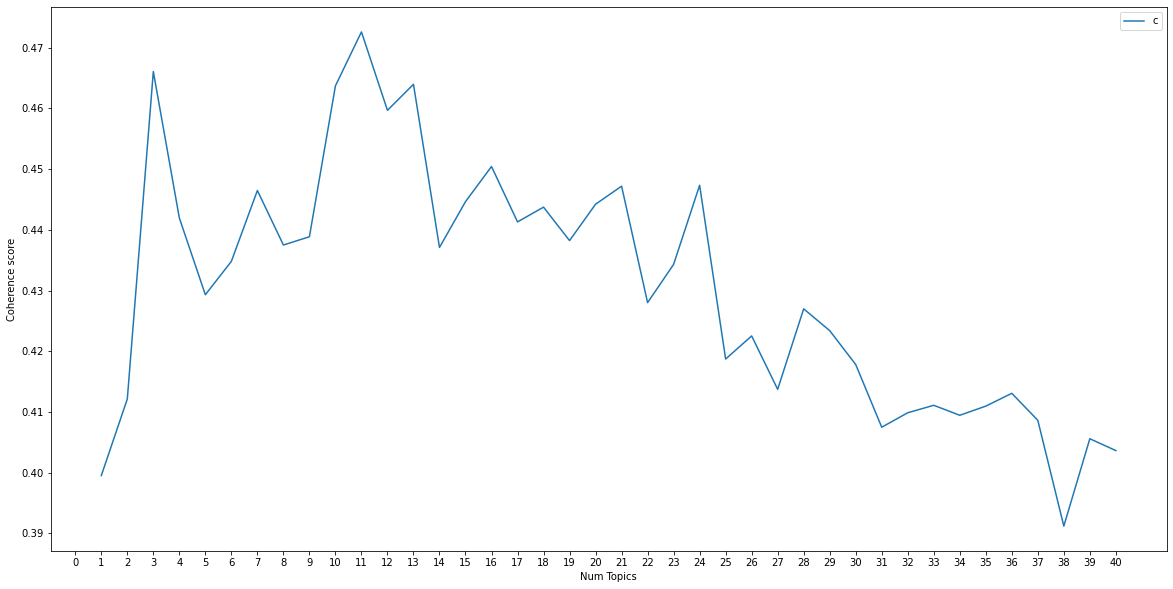

In [22]:
## Show plot
limit=41;start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.xticks(py.arange(0, 41, step=1))
plt.rcParams['figure.figsize'] = (20,10)
plt.show();

## 2. The LDA Model Visulization

### 2.1 Packages Importing

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

### 2.2 Visulization

In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LOldamodel, LOcorpus, id2word, sort_topics=False)
pyLDAvis.save_html(vis, 'lda.html')

## 3 Corpus Classification

### 3.1 PARS Corpus Reading 

In [25]:
pf = pd.read_csv('Olympics-ALL-PARS.csv', header = None, error_bad_lines = False)

b'Skipping line 5: expected 3 fields, saw 9\nSkipping line 37: expected 3 fields, saw 5\nSkipping line 41: expected 3 fields, saw 5\nSkipping line 81: expected 3 fields, saw 5\nSkipping line 106: expected 3 fields, saw 5\nSkipping line 107: expected 3 fields, saw 7\nSkipping line 108: expected 3 fields, saw 5\nSkipping line 112: expected 3 fields, saw 5\nSkipping line 126: expected 3 fields, saw 5\nSkipping line 127: expected 3 fields, saw 5\nSkipping line 139: expected 3 fields, saw 5\nSkipping line 140: expected 3 fields, saw 5\nSkipping line 142: expected 3 fields, saw 5\nSkipping line 149: expected 3 fields, saw 5\nSkipping line 162: expected 3 fields, saw 5\nSkipping line 163: expected 3 fields, saw 5\nSkipping line 186: expected 3 fields, saw 5\nSkipping line 188: expected 3 fields, saw 5\nSkipping line 190: expected 3 fields, saw 5\nSkipping line 191: expected 3 fields, saw 5\nSkipping line 194: expected 3 fields, saw 5\nSkipping line 213: expected 3 fields, saw 5\nSkipping line

In [26]:
pars = []
pars = pf[col]

### 3.2 PARS Corpus Processing

In [27]:
print('Document number: %d'% (len(pars)))
#freq_words(pars,10) 

Document number: 22764


In [28]:
#Tokenize the corpus 
pars= pars.map(lambda x: x.lower())

tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(pars)):
    pars[i] = tokenizer.tokenize(pars[i])

print('Tokens number: %d'% (len(Dictionary(pars))))
#freq_words(pars,10) 

Tokens number: 18540


In [29]:
#Remove the number
pars = [ [token for token in doc if not token.isnumeric()] for doc in pars]

print('Tokens number after removing number: %d'% (len(Dictionary(pars))))
#freq_words(pars,10) 

Tokens number after removing number: 18540


In [30]:
#Reomve stop words
pars = [ [token for token in doc if not token in stop_words] for doc in pars ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(pars))))
#freq_words(pars,10) 

Tokens number after removing stop words: 17685


In [31]:
#Remove short words (length < min_len)
pars = [ [token for token in doc if not len(token) < min_len] for doc in pars ]
print('Tokens number after removing short words: %d'% (len(Dictionary(pars))))
#freq_words(pars,10) 

Tokens number after removing short words: 17068


In [32]:
# Corpus Lemmatization
if lemmatization == 1:
    for i in range (len(pars)):
        pars[i] = lemmatize_sentence(pars[i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    pars = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in pars ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(pars))))
#freq_words(pars,10) 

Lemmatization with POS tags...
Tokens number after lemmatization: 14644


In [33]:
#remove stop words again
pars = [ [token for token in doc if not token in stop_words] for doc in pars ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(pars))))
#freq_words(pars,10) 

Tokens number after removing stop words: 14527


In [34]:
# Make bigram
P_bigrams_phases = Phrases(pars, min_count = 10)
for i in range(len(pars)):
    for token in P_bigrams_phases[pars[i]]:
        if '_' in token:
            pars[i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(pars))))
#freq_words(pars,10) 

Tokens number after adding bigram: 15129


### 3.3 Classify PARAS

In [35]:
Pcorpus = [LOdict.doc2bow(doc) for doc in pars]
#Make the Dataframe of the highest probable topics of each paragraph
MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus,minimum_probability = 0, per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
#    print(bz,listj[bz], i)
    MTopics.append([bz+1, listj[bz]])

MTopics = pd.DataFrame(MTopics)

classifer_document = pd.concat([pf.iloc[:,0:2],MTopics,pf.iloc[:,2:3]],axis=1)
classifer_document.columns = ["Par No.","Souce","The Highest Probable Topic", "Probability","Text"]

In [36]:
#adjust Dataframe's title to center
d = dict(selector="th",
    props=[('text-align', 'center')])

### 3.3.1 The Highest N ranked paragraphs for topic K

In [37]:
rank = 10                       #Set rank of for for topic 
topic = 5                        #Topic filter of the Highest ranked paragraphs

#1.	Highest N ranked paragraphs for topic K
classifer_document[classifer_document['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs for topic K')\
.set_table_styles([d])

,Par No.,Souce,The Highest Probable Topic,Probability,Text
332,384,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-220.txt,5,0.521174,This just will not do It really will not do Mr Cunnahs letter is a clear helpful letter totally credible as far as I can see I would not fault a word of it What I want to be clear about on behalf of the Committee is this when Sport England gave million to FAWNSL to build a dual use stadium on the Wembley site with the intention of its being the centrepiece stadiumbecause that was the basis upon which it was given and why the decision was made and why all the arguments about dual use and Picketts Lock and Mr Chris Smiths kitchen and all the rest of it came upto house the Olympic Games should we get them did Sport England at that time know that there would be a problem with the location of the village If it did not know it is culpable If it did know it is culpable But I would like to know one way or the other what the position wasMr Fytche The position was that Sport England invested in a project as I said before to create the opportunity for it to form the centrepiece of the bid should the Bid Committee consider that to be the best option You will find going back to those days in and the launch of the project which you mentioned the BOA themselves were talking about the potential for Wembley to be the centrepiece of the bid All parties involved in the debate at that time acknowledged Wembley could be the centrepiece of the bid It was later that the issues relating to athletics and Picketts Lock arose but at the time the decisions were taken around Wembley it was clear that all parties felt that Wembley could be the centrepiece and therefore no issues relating to the position of the village visavis Wembley were problematic to it going forward at that stage
337,391,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-220.txt,5,0.462335,Alan Keen I was aware and Ian Fytche is right it is not Sport England who were at fault with Wembley I am a West London MP so I was aware straightaway As soon as I saw the decision was taken to hold it in East London I knew there was going to be the need to build a stadium and I say it again just to make sure West Ham and Spurs are losing money now there is no way they can finance a stadium unless it is gifted to them and in a way Manchester City has been a bit of a gift When the decision was taken to move to East London I do not know whether people took account of the fact that a duplicate stadium had to be built and it would be of use to somebody but you would have to give it to them that is when the decision was taken that went against what Sport England envisaged when they put the money into Wembley Stadium That is about it I was aware from the moment it moved to East London In fact during this Committee hearing earlier on I said to people I would put money on the fact that the Olympics will be held at Wembley Stadium whatever you say about Picketts Lock Obviously that has changed So I was aware that we were duplicating the scene
155,172,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_120-121.txt,5,0.454950,That is one of the difficulties Another difficulty is our own track record in this area particularly our recent track record with Wembley with Picketts Lock and the World Athletics Championship in Julie Kirkbride has already mentioned the Dome Manchester itself as the Chairman has said was heading for difficulties before fairly severe action was taken That surely cannot be of assistance to usMr Reedie I hope and rather believe that memories are shorter rather than longer By the time comes I would expect Wembley to be well under way as being the best football stadium in the world By that stage we will be a bit further away from the Picketts Lock decision In Olympic sporting terms that was the damaging one Although the Commonwealth Games were a struggle to bring to fruition they were a huge success and the rest of the world saw that success They were not hugely interested two 

### 3.3.2 The Highest N ranked paragraphs overall

In [38]:
rank = 10                          #Set rank of for for topic 

#2.	Highest N ranked paragraphs overall
classifer_document.nlargest(rank, 'Probability')\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs overall')\
.set_table_styles([d])

,Par No.,Souce,The Highest Probable Topic,Probability,Text
15756,16064,Olympics-All-PARS/NewChunk6/NAO_Preparations_for_the_Olympics_-_Progress_report_-_Feb_2010.pdf.txt,11,0.629929,The Delivery Authoritys Programme Baseline of November set out the scope expected costs cash flow risks assumptions and key milestones for each of its projects and is the basis against which its costs will be reported for the life of the programme The scope of some projects has changed and new ones have been added with all changes requiring approval by the Delivery Authoritys Change Control Board which is attended by the Olympic Executive and material changes reported to the Olympic Projects Review Group Changes requiring a call on contingency are subject to approval under the arrangements set out in Appendix The Delivery Authority reports the anticipated final cost of its programme each quarter to reflect approved changes cost pressures and savings opportunities During the second half of the Delivery Authority produced a detailed report setting out the scope and cost of each project to reflect all changes to the Programme since November As at December the Delivery Authority had completed per cent of its capital programme against a target of per cent The capital programme includes Olympic venues and infrastructure capital transport projects the Olympic Village and post Games venue transformation work The Delivery Authority has agreed completion dates for handover to LOCOG All main construction and infrastructure projects are planned to complete to this timetable Three have been completed The Delivery Authority has also set itself more challenging target completion dates to accommodate any potential slippage in its delivery programme Of the remaining projects seven are on target to meet these dates while seven will be completed after them but in time for handover Achieving handover dates is important to allow sufficient time for the preparation fit out of the venues for the Games where this is not the responsibility of the Delivery Authority and for testing and other preparations necessary before the Games
13681,13984,Olympics-All-PARS/NewChunk5a/NAO_Preparations_for_the_Olympics_-_Progress_report_-_June_2008.pdf.txt,11,0.587478,n million hereafter referred to as the Olympic Delivery Authority Programme Contingency is potentially available for Olympic Delivery Authority programme wide risks The Olympic Delivery Authoritys quantified risk assessment in November indicated that at a level of per cent probability a further million in addition to the Authoritys base budget of million would be sufficient to deliver the Authoritys planned programme Eighty per cent is a generally accepted industry standard Olympic Delivery Authority Programme Contingency relates to identified risks with the potential to impact on projects across the Authoritys programme for example risks concerning the interdependency of projects on the Olympic Park the impact of exchange rate fluctuations unexpected ground conditions and the availability of materials Arrangements for the management of the million have been put in place by the Government Olympic Executive so that any application by the Olympic Delivery Authority for access to the Olympic Delivery Authority Programme Contingency will be subject to scrutiny by the Olympic Projects Review Group and approval by the Minister for the Olympics Release of the lottery funded element of Olympic Delivery Authority Programme Contingency is subject to approval by the Olympic Lottery Distributor
9249,9523,Olympics-All-PARS/NewChunk4/NAO_Preparing_for_sporting_success_-_March_2008.pdf.txt,9,0.543067,The Committee of Public Accounts recommended in their report that on the basis that the resources were known UK Sport should decide its medal table targets for and reflect them in the targets it agreed with individual sports before reviewing those targets in the light of performance at Beijing in UK Sports response to this recommendation in Oc

### 3.3.3 The Highest N ranked paragraphs from each topic

In [39]:
rank = 3                          #Set rank of for for topic 

#3.	Highest N ranked paragraphs from each topic K
classifer_document.groupby(by='The Highest Probable Topic').apply(lambda x:x.nlargest(rank, 'Probability'))\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs from each topic')\
.set_table_styles([d])

### 3.3.4 The Highest N ranked paragraphs from topic K with threshold

In [40]:
minimum_probability = 0.5 #Topics with an assigned probability lower than this threshold will be discarded.

#4.	Highest N ranked paragraphs where the belong() function is greater than the threshold for M topics at a time
T_MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus, minimum_probability = minimum_probability, per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    if minimum_probability == 0:
        bz=listj.index(max(listj))
        T_MTopics.append([bz+1, listj[bz]])
    else:
        if listj:
            bz=listj.index(max(listj))
            topics= ','.join(str(a) for a in re.findall(r"(\d+),",str(max(i))) )
            T_MTopics.append([int(topics)+1, listj[bz]])
        else:
            T_MTopics.append(['None',0])
        

T_MTopics = pd.DataFrame(T_MTopics)

classifer_document_threshold = pd.concat([pf.iloc[:,0:2],T_MTopics,pf.iloc[:,2:3]],axis=1)
classifer_document_threshold.columns = ["Par No.","Souce","The Highest Probable Topic", "Probability","Text"]

In [42]:
rank = 5                          #Set rank of for for topic 
topic = 2                        #Topic filter of the Highest ranked paragraphs

classifer_document_threshold[classifer_document_threshold['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs from topic K with threshold')\
.set_table_styles([d])

,Par No.,Souce,The Highest Probable Topic,Probability,Text
5869,6122,Olympics-All-PARS/NewChunk3/Report_and_Minutes_-_Jan_2007.pdf.txt,2,0.508189,The potential for a further call on the National Lottery Distribution Fund above the million foreseen in when the funding package was drawn up has never been ruled out by Secretary of State Indeed she reiterated to the Committee both in July and in November that she would be prepared to draw further on Lottery revenues Any such transfer would be under an order subject to affirmative resolution in Parliament The Explanatory Notes provided by the Government to the Horserace Betting and Olympic Lottery Act state that such an order under section of the Act would be made only in exceptional circumstances We note the warning from the Lottery Forum that any such requirement for additional Lottery funding would reduce NLDF distributors ability to deliver a full and balanced portfolio of activity We received evidence in our recent inquiry into heritage about the damaging impact on the Heritage Lottery Fund of the reduction in Lottery income this impact is likely to be equally matched in the arts and voluntary sectors A further transfer of Lottery revenues from the National Lottery Distribution Fund to the Olympic Lottery Distribution Fund above the million already identified would penalise good causes yet further We believe that any further diversion of money from the Lottery would reduce the money available for each of the good causes and it is not our preferred option for funding any overspend


### 4. Build an Interactive App

In [44]:
import plotly.express as px  # (version 4.7.0)
import plotly.graph_objects as go

from jupyter_dash import JupyterDash

import dash  # (version 1.12.0) pip install dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash_table.Format import Format, Scheme, Trim
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate


In [46]:
# Set up the app
external_stylesheets = [dbc.themes.BOOTSTRAP, "assets/bootstrap.min.css"]
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)


pyLDAcard = dbc.Card(
    [
            dbc.CardHeader(html.H4("Topic Distribution in overall Documents")),
            dbc.CardBody(
            [
                dbc.Row(
                        dbc.Col(
                            [
                                html.Embed(src = "assets/lda.html" ,style={ 'position': 'relative', 'left': '-118px', 'top': '-50px','width':'1250px', 'height':'860px', 'transform': 'scale(0.88)'}), 
                            ]
                        )
                )
            ]
        ),
    ]
)


table_card = dbc.Card(
    [
        dbc.CardHeader(
            dbc.Row([
                  dbc.Col(html.H4("Paragraphs Classification"))
            ])            
        ),
        
        
        dbc.CardHeader(
                         dbc.Row(
                            [
                            dbc.Col(
                            [
                                html.H6("Threshold"),
                                dcc.Slider(
                                            id='slider',
                                            min=0,
                                            max=1,
                                            step=0.01,
                                marks={
                                    0: '0.0',
                                    0.05: '0.05',
                                    0.1: '0.1',
                                    0.15: '0.15',
                                    0.2: '0.2',
                                    0.25: '0.25',
                                    0.3: '0.3',
                                    0.35: '0.35',
                                    0.4: '0.4',
                                    0.45: '0.45',
                                    0.5: '0.5',
                                    0.55: '0.55',
                                    0.6: '0.6',
                                    0.65: '0.65',
                                    0.7: '0.7',
                                    0.75: '0.75',
                                    0.8: '0.8',
                                    0.85: '0.85',
                                    0.9: '0.9',
                                    0.95: '0.95',
                                    1: '1.0',
                                },
                                        value=0.1,
                                        ),html.Div(style={'width': '1000px'})
                            ]
                        ),
                        dbc.Col(
                        [
                                html.H6("Topic Selection"),
                                dcc.Input(id="topic_selection", type="number",min=1, max=11, step=1, value=1),
                                html.Div(style={'width': '100px'})
                        ]
                        ),
                          dbc.Col(
                        [
                                html.H6("Rank Selection"),
                                dcc.Input(id="rank_selection", type="number",min=1, max=20, step=1,value=5),
                                html.Div(style={'width': '100px'})
                        ]
                        ),
                                dbc.Col(
                                    [
                                        html.H6("Paragraphs Classification Mode"),
                                        dcc.Dropdown(
                                                            id='dropdown',
                                                            options=[
                                                                {'label': 'The highest N ranked paragraphs for topic K', 'value': 'c1'},
                                                                {'label': 'The highest N ranked paragraphs overall', 'value': 'c2'},
                                                                {'label': 'The highest N ranked paragraphs from each topic', 'value': 'c3'}
                                                            ],
                                               #             value = 'c1',
                                                            searchable=False,
                                                            clearable=False,
                                                            placeholder="Select a paragraphs classification mode",
                                                        ),html.Div(style={'width': '380px'})
                                    ]
                                ),                                
                ]
            )                    
                ),
        
        dbc.CardBody(
                dbc.Col([
                    dash_table.DataTable(),html.Div(id="data_table")           
                ])    
                ),
        
        dbc.CardFooter(
            dbc.Row([
                dbc.Col(
                                    [
                                        html.H6('Please click the "Submit" button after setting the parameters above'),html.Div(style={'width': '500px'})

                                    ]
                                ),
                                
                dbc.Col(
                                    [
                                        dbc.Button("Submit", id='submit', color="success"),
                                        html.Div(id='button')
                                    ]
                                )
                ])
                )       
    ]
)
        
app.layout = html.Div(
    [
        dbc.Container(
            [dbc.Row(
                [
                dbc.Col(pyLDAcard,md=7), 
                dbc.Col(table_card,md=5)
            ]             
            )
            ],
            fluid=True,
        ),
    ]
)

@app.callback(
    Output('data_table','children'),
    Input('submit', 'n_clicks'), Input('dropdown', 'value'), Input('slider', 'value'), Input('topic_selection','value'), Input('rank_selection','value')
     )

def update_datatable(n_clicks, dropdown_value, slider_value,topic_value,rank_value):
  
    ctx = dash.callback_context
    if not ctx.triggered:
        button_id = 'No clicks'
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]
    
#    print(button_id)
                 
    if button_id=="submit":
        topic = topic_value                        #Topic filter of the Highest ranked paragraphs
        rank = rank_value                          #Set rank of for for topic 
#        print(topic_value)
#        print(rank_value)   
        
        minimum_probability = slider_value #Topics with an assigned probability lower than this threshold will be discarded.
#        print(minimum_probability)            

        T_MTopics =  list()
        for i in LOldamodel.get_document_topics(Pcorpus, minimum_probability = minimum_probability, per_word_topics=False)[:]:
            listj=[]
            for j in i:
                listj.append(j[1])
            if minimum_probability == 0:
                bz=listj.index(max(listj))
                T_MTopics.append([bz+1, listj[bz]])
            else:
                if listj:
                    bz=listj.index(max(listj))
                    topics= ','.join(str(a) for a in re.findall(r"(\d+),",str(max(i))) )
                    T_MTopics.append([int(topics)+1, listj[bz]])
                else:
                    T_MTopics.append(['None',0])
                
        
        T_MTopics = pd.DataFrame(T_MTopics)
        
        classifer_document_threshold = pd.concat([pf.iloc[:,0:2],T_MTopics,pf.iloc[:,2:3]],axis=1)
        classifer_document_threshold.columns = ["Par No.","Souce","The Highest Probable Topic", "Probability","Text"]
                        
        if dropdown_value=='c1':
            c_df = classifer_document_threshold[classifer_document_threshold['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')
        elif dropdown_value=='c2':
            c_df = classifer_document_threshold[classifer_document_threshold['The Highest Probable Topic'] != 'None'].nlargest(rank, 'Probability')
        elif dropdown_value=='c3':
            c_df = classifer_document_threshold[classifer_document_threshold['The Highest Probable Topic'] != 'None'].groupby(by='The Highest Probable Topic').apply(lambda x:x.nlargest(rank, 'Probability'))
        else:
            return None
#        print(dropdown_value)
        
        table = dash_table.DataTable(
                                    id="table-line-1",
                                    columns=[
                                                dict(id=c_df.columns[0], name=c_df.columns[0]),
                                                dict(id=c_df.columns[1], name=c_df.columns[1]),
                                                dict(id=c_df.columns[2], name=c_df.columns[2]),
                                                dict(id=c_df.columns[3], name=c_df.columns[3], type='numeric', format=Format(precision=3, scheme=Scheme.fixed)), 
                                                dict(id=c_df.columns[4], name=c_df.columns[4]),            
                                            ],
                                    data=c_df.to_dict("records"),
                       #             page_action='none',
                                    page_size=5,
                                    style_table={'height': '1000px', 'overflowY': 'auto'},
                                    fixed_rows={'headers': True},
                                    style_header={ 'border': '1px solid black', 'fontWeight': 'bold','textAlign': 'center', 'fontSize':'1px'},
                                    style_cell={  'fontSize':'1px','border': '1px solid grey','minWidth': 10, 'maxWidth': 30, 'width': 30,'whiteSpace': 'normal','height': 'auto','lineHeight': '15px','textAlign': 'center','textOverflow': 'ellipsis', 'maxWidth': 0},
                                    css=[{
                                            'selector': '.dash-spreadsheet td div',
                                            'rule': '''
                                                line-height: 15px;
                                                max-height: 300px; min-height: 50px; height: 300px;
                                                display: block;
                                                overflow-y: hidden;
                                            '''
                                        }],
                                     style_cell_conditional=[
                                                                    {'if': {'column_id': 'Par No.'},'width': '7%'},
                                                                    {'if': {'column_id': 'Souce'},'width': '8%'},
                                                                    {'if': {'column_id': 'The Highest Probable Topic'},'width': '10%' },
                                                                    {'if': {'column_id': 'Probability'},'width': '10%'},
                                                                    {'if': {'column_id': 'Text'},'width': '75%','textAlign': 'left'},
    
                                                                ],
    
                                    style_as_list_view=True,
                 )
#        print('end')
        return table
          
app.run_server(mode = 'external')

Dash app running on http://127.0.0.1:8050/


In [47]:
app._terminate_server_for_port('localhost', 8050)